In [1]:
import numpy as np
import itertools
import scipy as sp
import matplotlib.pyplot as plt

# Import my modules
from Auxiliar_Module import Auxiliar
from Models import GaussianModel

# Package for multiple precision
import mpmath as mp
mp.mp.dps = 30
print(mp.mp)

cm_in_inches = Auxiliar.cm_in_inches()

Mpmath settings:
  mp.prec = 103               [default: 53]
  mp.dps = 30                 [default: 15]
  mp.trap_complex = False     [default: False]


In [52]:
# Setting up interaction
g_plot  = 50
σ_plot  = 0.05

n_basis_c    = 40
n_basis_rel  = 40
n_basis_Φ    = 30 # n_basis_c+n_basis_rel-1

E_trunc = 10
range_iε = [0,2,4]

TBM_tensor = Auxiliar.TBM_tensor_calc(n_basis_c, n_basis_rel)

model_plot = GaussianModel(g_plot, σ_plot, n_basis_rel, n_basis_Φ, TBM_tensor)

# Dict of One-coboson states
OneCobosonStates = {}
for nc in range(n_basis_c):
    for iε in range_iε:
        OneCobosonStates[f'B_{nc}{iε}'] = model_plot.oneCoboson(nc, iε)

OneCobosonStates = dict(sorted(OneCobosonStates.items(), key=lambda x:x[1].energy()))
print(f'OneCob max energy = {OneCobosonStates[list(OneCobosonStates.keys())[-1]].energy()}')

# Dict of Two-coboson states with nc_1 + nc_2 < nc_trunc
TwoCobosonStates_aux = list(itertools.combinations_with_replacement(OneCobosonStates.keys(), 2))
TwoCobosonStates_dic = {}
for state in TwoCobosonStates_aux:
    state_0 = OneCobosonStates[state[0]]
    state_1 = OneCobosonStates[state[1]]
    E_sep_state = state_0.energy() + state_1.energy()
    if (E_sep_state < E_trunc):
        TwoCobosonStates_dic.update({state:E_sep_state})
        
TwoCobosonStates_dic = dict(sorted(TwoCobosonStates_dic.items(), key=lambda x:x[1]))
TwoCobosonStates = list(TwoCobosonStates_dic.keys())
n_BASIS = len(TwoCobosonStates)
print(f"n_BASIS = {n_BASIS}")

OneCob max energy = 45.07665196559826
n_BASIS = 27


Autovalores =  [0.50000347 0.50008174 0.50008218 0.50012714 0.50016731 0.50017973
 0.500308   0.50049541 0.5005084  0.50054002]
det(S) =  1.966646559372812e-06


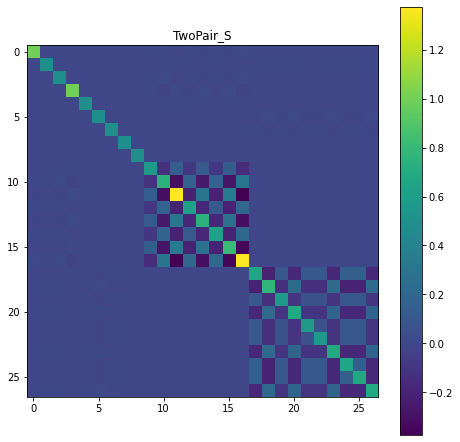

In [53]:
TwoPair_Λ = np.zeros((n_BASIS,n_BASIS))
TwoPair_S = np.zeros((n_BASIS,n_BASIS))

# Sweeps matrices as (I,I) -> (I-1,I) -> (I-2,I) -> ... -> (0,I) for I = 0,..,n_BASIS 
for I in range(n_BASIS):
    for F in range(I,-1,-1):
        # (0,0) (0,1) ... (0,I) ... (0,N) 
        #   .   (1,1)  ^    ^    ^    ^      
        #   .     .    x    ^    ^    ^  
        #   .     .    .  (I,I)  ^    ^   
        #   .     .    .    .    x    ^    
        #   .     .    .    .    .  (N,N)
        
        f_1 = OneCobosonStates[TwoCobosonStates[F][0]]
        f_2 = OneCobosonStates[TwoCobosonStates[F][1]]
        i_1 = OneCobosonStates[TwoCobosonStates[I][0]]
        i_2 = OneCobosonStates[TwoCobosonStates[I][1]]
        
            
        TwoPair_Λ[F,I] = model_plot.Λ_Scatt (f_2, i_2,
                                             f_1, i_1)
        TwoPair_Λ[I,F] = TwoPair_Λ[F,I]
        
        Kronecker_δ = Auxiliar.Kronecker_δ 
        δ_FI = Kronecker_δ(f_1,i_1)*Kronecker_δ(f_2,i_2) + Kronecker_δ(f_1,i_2)*Kronecker_δ(f_2,i_1)        
        TwoPair_S[F,I] = δ_FI - TwoPair_Λ[F,I]
        
        # Normalizing the states |I> and |F>
        norm_cte = (TwoPair_S[F,F]*TwoPair_S[I,I])**(-0.5) 
        
        #TwoPair_S[F,I] = norm_cte * TwoPair_S[F,I]
        TwoPair_S[I,F] = TwoPair_S[F,I]

print('Autovalores = ', sp.linalg.eigh(TwoPair_S)[0][0:10])
print('det(S) = ',sp.linalg.det(TwoPair_S))

plt.figure(figsize = (20*cm_in_inches,20*cm_in_inches))
plt.imshow(TwoPair_S)
plt.title("TwoPair_S")
plt.colorbar()
plt.show()

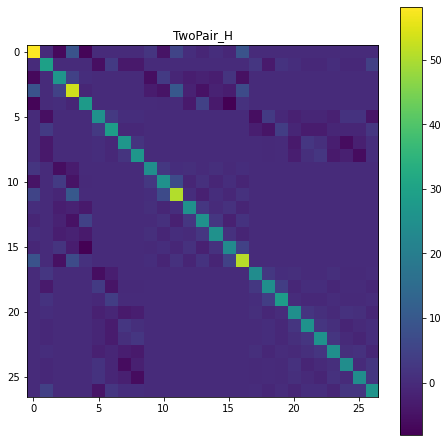

In [54]:
TwoPair_Λ = np.zeros((n_BASIS,n_BASIS))
TwoPair_S = np.zeros((n_BASIS,n_BASIS))
TwoPair_H = np.zeros((n_BASIS,n_BASIS))
TwoPair_FermionOccuMatrix = np.zeros((n_BASIS,n_BASIS,n_basis_Φ,n_basis_Φ))

# Sweeps matrices as (I,I) -> (I-1,I) -> (I-2,I) -> ... -> (0,I) for I = 0,..,n_BASIS 
for I in range(n_BASIS):
    for F in range(I,-1,-1):
        # (0,0) (0,1) ... (0,I) ... (0,N) 
        #   .   (1,1)  ^    ^    ^    ^      
        #   .     .    x    ^    ^    ^  
        #   .     .    .  (I,I)  ^    ^   
        #   .     .    .    .    x    ^    
        #   .     .    .    .    .  (N,N)
        
        f_1 = OneCobosonStates[TwoCobosonStates[F][0]]
        f_2 = OneCobosonStates[TwoCobosonStates[F][1]]
        i_1 = OneCobosonStates[TwoCobosonStates[I][0]]
        i_2 = OneCobosonStates[TwoCobosonStates[I][1]]
        
        TwoPair_Λ[F,I] = model_plot.Λ_Scatt (f_2, i_2,
                                             f_1, i_1)
        TwoPair_Λ[I,F] = TwoPair_Λ[F,I]
        
        Kronecker_δ = Auxiliar.Kronecker_δ 
        δ_FI = Kronecker_δ(f_1,i_1)*Kronecker_δ(f_2,i_2) + Kronecker_δ(f_1,i_2)*Kronecker_δ(f_2,i_1)        
        TwoPair_S[F,I] = δ_FI - TwoPair_Λ[F,I]
        
        TwoPair_H[F,I] = (i_1.energy() + i_2.energy())*TwoPair_S[F,I] \
                        + model_plot.ξ_Scatt(f_2, i_2,f_1, i_1) - model_plot.ξIn_Scatt (f_2, i_2, f_1, i_1) \
                        + model_plot.ξ_Scatt(f_1, i_2,f_2, i_1) - model_plot.ξIn_Scatt (f_1, i_2, f_2, i_1)
        
        TwoPair_FermionOccuMatrix[F,I] = model_plot.TwoCobosonSpace_FermionOccupationMatrix (f_2, i_2, f_1, i_1)
        
        norm_cte = (TwoPair_S[F,F]*TwoPair_S[I,I])**(-0.5) # Normalizing the states |I>, |F>
        
        #TwoPair_FermionOccuMatrix[F,I] = norm_cte * TwoPair_FermionOccuMatrix[F,I]
        TwoPair_FermionOccuMatrix[I,F] = TwoPair_FermionOccuMatrix[F,I]
        
        #TwoPair_S[F,I] = norm_cte * TwoPair_S[F,I]
        TwoPair_S[I,F] = TwoPair_S[F,I]
        
        #TwoPair_H[F,I] = norm_cte * TwoPair_H[F,I] # Normalizing wrt |I>, |F>
        TwoPair_H[I,F] = TwoPair_H[F,I]
  

plt.figure(figsize = (20*cm_in_inches,20*cm_in_inches))
plt.imshow(TwoPair_H)
plt.title("TwoPair_H")
plt.colorbar()
plt.show()

In [83]:
sp.linalg.eigh(TwoPair_H,TwoPair_S)[0][0:5]

array([ 8.2114448 ,  9.21144751, 25.18320736, 26.18319374, 32.45220194])

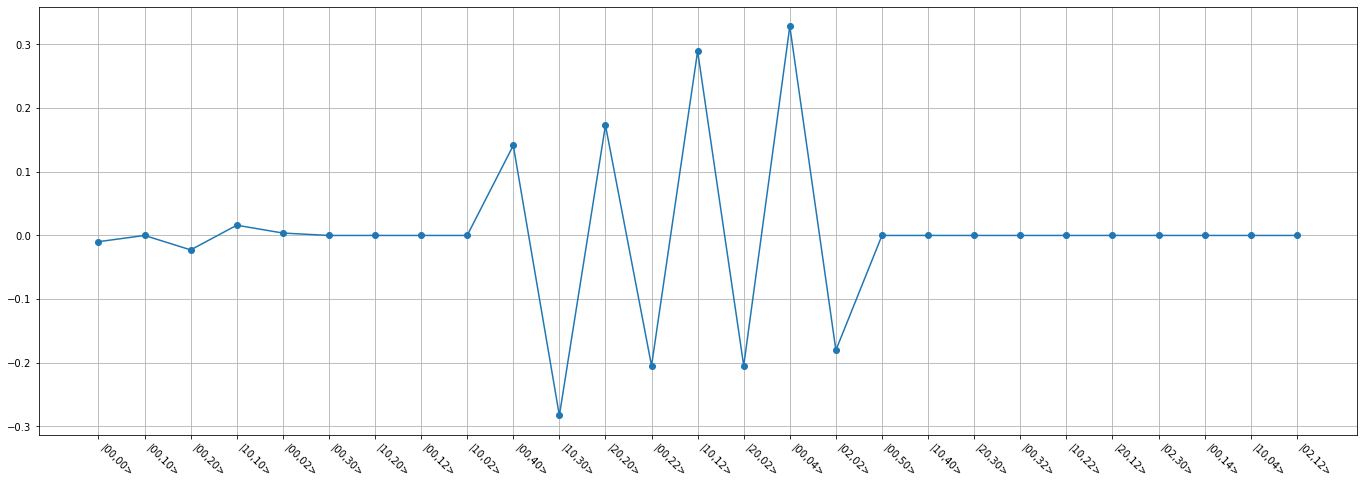

In [86]:
TwoCobosonStates_ticks = []
for state in TwoCobosonStates:
    TwoCobosonStates_ticks.append(f"|{state[0][2:]},{state[1][2:]}>")
plt.figure(figsize = (60*cm_in_inches,20*cm_in_inches))
plt.plot(sp.linalg.eigh(TwoPair_H,TwoPair_S)[1][:,0], marker = 'o')
plt.xticks(range(len(TwoCobosonStates_ticks)), TwoCobosonStates_ticks, rotation = -45, horizontalalignment = 'left')
plt.grid()
plt.show()

Tr ρ_1 = 1.9999992957303574


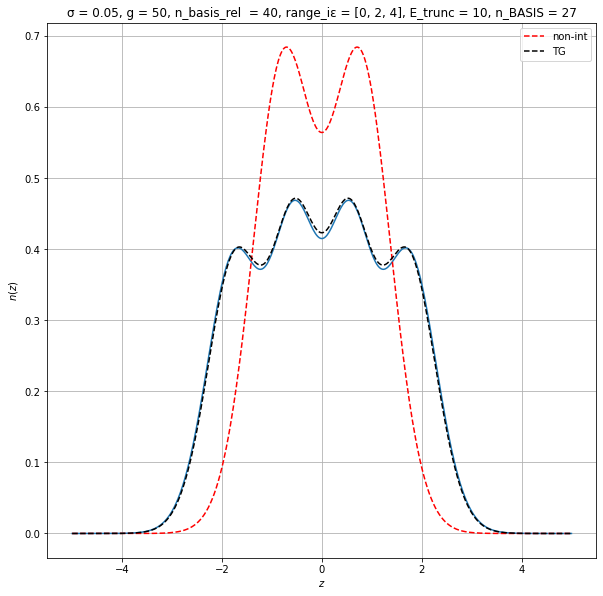

In [56]:
fig, axs = plt.subplots(1, 1,
                        sharey = True, sharex = True,
                        figsize = (25*cm_in_inches,25*cm_in_inches))

z_arr = np.linspace(-5,5,500)

ρ_1 = np.zeros((n_basis_Φ,n_basis_Φ))

# Normalized with respect to TwoPair_S
GS_coef = sp.linalg.eigh(TwoPair_H,TwoPair_S)[1][:,0]

ρ_1 = np.einsum('j,jkl',
                GS_coef,
                np.einsum('i,ijkl',
                          GS_coef,
                          TwoPair_FermionOccuMatrix))

onebody_dens_arr = Auxiliar.OneBodyDensity_from_ρ_1(ρ_1, z_arr)
axs.plot(z_arr,onebody_dens_arr)

onebody_dens_0_arr = np.array([Auxiliar.onebody_dens_0(2,z) for z in z_arr])
axs.plot(z_arr,onebody_dens_0_arr, 'r--', label = 'non-int')

onebody_dens_TG_arr = np.array([Auxiliar.onebody_dens_TG(2,z) for z in z_arr])
axs.plot(z_arr,onebody_dens_TG_arr, 'k--', label = 'TG')

print(f"Tr ρ_1 = {np.trace(ρ_1)}")

axs.legend()
axs.set_title(f'σ = {σ_plot}, g = {g_plot}, n_basis_rel  = {n_basis_rel}, range_iε = {range_iε}, E_trunc = {E_trunc}, n_BASIS = {n_BASIS}')
axs.set(xlabel='$z$')
axs.set(ylabel='$n(z)$')        
axs.grid()

## with orthonormalization...

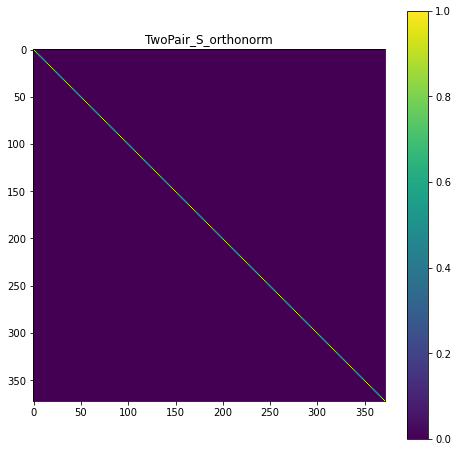

In [48]:
eigvals_S, U = sp.linalg.eigh(TwoPair_S)
U_orthonorm = U * eigvals_S**-0.5
TwoPair_S_orthonorm = U_orthonorm.T @ TwoPair_S @ U_orthonorm
plt.figure(figsize = (20*cm_in_inches,20*cm_in_inches))
plt.imshow(TwoPair_S_orthonorm)
plt.title("TwoPair_S_orthonorm")
plt.colorbar()
plt.show()

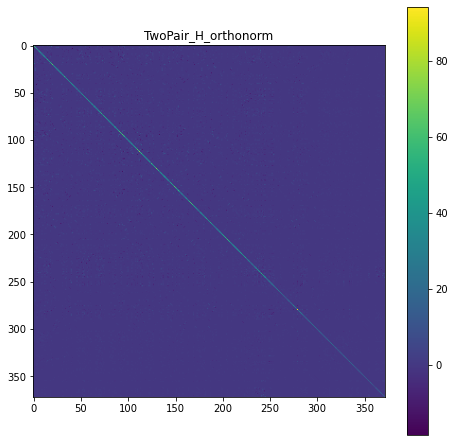

In [50]:
TwoPair_H_orthonorm = U_orthonorm.T @ TwoPair_H @ U_orthonorm
plt.figure(figsize = (20*cm_in_inches,20*cm_in_inches))
plt.imshow(TwoPair_H_orthonorm)
plt.title("TwoPair_H_orthonorm")
plt.colorbar()
plt.show()

In [51]:
sp.linalg.eigh(TwoPair_H_orthonorm)[0][0:5]

array([8.20089263, 8.65141343, 9.20089683, 9.65132975, 9.88930674])

Tr ρ_1 = 1.9999857613205358


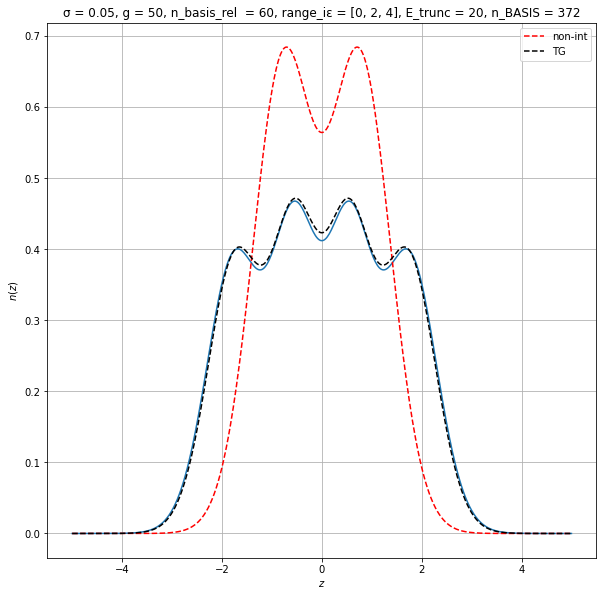

In [52]:
fig, axs = plt.subplots(1, 1,
                        sharey = True, sharex = True,
                        figsize = (25*cm_in_inches,25*cm_in_inches))

z_arr = np.linspace(-5,5,500)

ρ_1 = np.zeros((n_basis_Φ,n_basis_Φ))

# TwoPair_FermionOccuMatrix wrt orthonormalbasis
TwoPair_FermionOccuMatrix_orthonorm = np.einsum('ip,iqkl->pqkl',
                                                U_orthonorm,
                                                np.einsum('ijkl,jq->iqkl', TwoPair_FermionOccuMatrix, U_orthonorm))

# Normalized with respect to TwoPair_S
GS_coef = sp.linalg.eigh(TwoPair_H_orthonorm)[1][:,0]

ρ_1 = np.einsum('j,jkl',
                GS_coef,
                np.einsum('i,ijkl',
                          GS_coef,
                          TwoPair_FermionOccuMatrix_orthonorm))

onebody_dens_arr = Auxiliar.OneBodyDensity_from_ρ_1(ρ_1, z_arr)
axs.plot(z_arr,onebody_dens_arr)

onebody_dens_0_arr = np.array([Auxiliar.onebody_dens_0(2,z) for z in z_arr])
axs.plot(z_arr,onebody_dens_0_arr, 'r--', label = 'non-int')

onebody_dens_TG_arr = np.array([Auxiliar.onebody_dens_TG(2,z) for z in z_arr])
axs.plot(z_arr,onebody_dens_TG_arr, 'k--', label = 'TG')

print(f"Tr ρ_1 = {np.trace(ρ_1)}")

axs.legend()
axs.set_title(f'σ = {σ_plot}, g = {g_plot}, n_basis_rel  = {n_basis_rel}, range_iε = {range_iε}, E_trunc = {E_trunc}, n_BASIS = {n_BASIS}')
axs.set(xlabel='$z$')
axs.set(ylabel='$n(z)$')        
axs.grid()